# Implementing the SPT Model

Modifications: Johnny Esteves\
Author: Allen Pinjic - Created on June 6th, 2022

In [1]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pylab as plt
import pymc3 as pm
import aesara
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import math

In [3]:
%matplotlib inline

## Retrieving SPT Data

In [4]:
fname = '../data_set/sptecs_catalog_oct919.fits'

data = Table(getdata(fname))
data[:2]

SPT_ID,RA,DEC,FIELD,XI,THETA_CORE,REDSHIFT,REDSHIFT_UNC,SPECZ,REDSHIFT_SOURCE,RM_PROB,CL_NOTES,M500,M500_UERR,M500_LERR,LAMBDA_CHISQ,LAMBDA_CHISQ_E,RADIO_CONTAM,STRONG_LENS,IMAGE_SOURCE,SPECZ_REF,STRONG_LENS_REF,PHOTOMETRIC_ZREF
str16,float64,float64,str11,float32,float32,float32,float32,int16,float32,float32,str50,float32,float32,float32,float32,float32,float32,float32,float32,str38,str19,str29
SPT-CLJ0000-2518,0.072338357,-25.303935,ra1hdec-25,5.073545,1.5,0.0,0.0,0,0.0,0.0,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,,,
SPT-CLJ0005-3751,1.4383179,-37.854369,ra1hdec-35,6.336327,0.75,0.48295808,0.0072415886,0,4.0,0.00061007956,-,5.419,0.887,0.887,86.40839,4.7352147,0.0,1.0,3.0,,,


In [5]:
sz_signal = np.array(data['XI'])
lambda_chisq = np.array(data['LAMBDA_CHISQ'])
lambda_chisqE = np.array(data['LAMBDA_CHISQ_E'])
redshift = np.array(data['REDSHIFT'])

(array([17., 64., 75., 45., 27., 19., 16., 13.,  7.,  7.]),
 array([14.481873, 14.530734, 14.579596, 14.628457, 14.677319, 14.726179,
        14.775041, 14.823902, 14.872764, 14.921625, 14.970487],
       dtype=float32),
 <BarContainer object of 10 artists>)

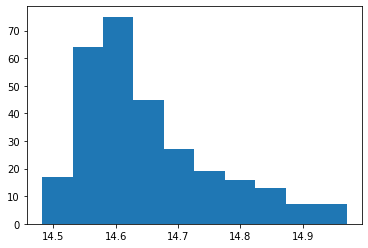

In [6]:
plt.hist(np.log10(data['M500'][lambda_chisq>20]*1e14))

## Define Model

In [7]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
cosmology.setCosmology('WMAP9')

def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

In [8]:
# LogNormal models
# see https://en.wikipedia.org/wiki/Log-normal_distribution
M0 = 3e14
Ez0 = E(0)
def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0))

def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

In [9]:
# set up integration vectors
mvec = np.logspace(13.8, 15.5, 75)
lbdvec = np.linspace(3,1.2*np.max(lambda_chisq),150)
zetavec = np.linspace(1,1.1*np.max(sz_signal),75)
# lbdvec = np.exp(np.arange(np.log(5),np.log(1.2*np.max(lambda_chisq)),0.032))
# zetavec = np.exp(np.arange(np.log(1),np.log(1.1*np.max(sz_signal)),0.045))

print('Vector size')
print(mvec.size)
print(lbdvec.size)
print(zetavec.size)

Vector size
75
150
75


In [10]:
zvec = np.linspace(0., 1.3, 100)
zzv, mm = np.meshgrid(zvec, mvec)
from scipy import interpolate
halo_mass_function2 = interpolate.interp1d(zvec, halo_mass_function(mm, zzv), kind='cubic')

In [11]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec

def log_likelihood(theta, z, y, yerr, eps=1e-9):
    # defining variables
    lbd_hat, chisi = y[0], y[1]
    lbd_error = yerr
    nsize = len(lbd_hat)
    
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]

    # setting grid for integration
    mm, zz = np.meshgrid(mvec, z)

    # calling predictions; 
    ln_lbd_pred = (ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda],mm,zz)).T
    ln_zeta_pred= (ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze],mm,zz)).T

    halo_mass_func = (halo_mass_function2(z))
        
    # integrating over zeta, lambda
    prob = marginalize_over_lbd_zeta(lbd_hat, lbd_error, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                     scatter_lambda, scatter_sze, rho)
    log_prob = np.log(prob)
    return np.sum(log_prob)

def marginalize_over_lbd_zeta(lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                              scatter_lambda, scatter_zeta, rho):
    # integrating over zeta, lambda
    nsize = len(lbd_hat)
    # integrating over zeta, lambda
    res_zeta = np.full((zetavec.size, nsize),np.nan,dtype=float)
    res_lbd = np.full((lbdvec.size, nsize),np.nan,dtype=float)

    for j,li in enumerate(lbdvec):
        for i,zi in enumerate(zetavec):
            res_zeta[i] = compute_dn_dlbd_dzeta(li, zi, lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                              scatter_lambda, scatter_sze, rho)
        # integrate over zeta for a given lambda
        res_lbd[j] = np.trapz(res_zeta, axis=0)
    # integrate over lambda
    prob = np.trapz(res_lbd, x=lbdvec, axis=0)
    # normalize over all posibilities
    prob = prob/np.sum(prob)
    return prob

## likelihood including the errors
def compute_dn_dlbd_dzeta(lbd, zeta, lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                          scatter_lambda, scatter_zeta, rho, eps=1e-9):
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)

    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

    # defining standirized variables
    lbd_std = (lbd - np.exp(ln_lbd_pred))/s_lambda
    zeta_std = (zeta - np.exp(ln_zeta_pred))/s_zeta

    # lbd_likelihood
    lp_lbd  = -rho_inv*lbd_std**2/2 -((lbd-lbd_hat)/lbd_err)**2/2.

    # zeta likelihood
    lp_zeta = -rho_inv*zeta_std**2/2 -(chisi-np.sqrt(zeta**2+3))**2/2.

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std

    lp_total_m = lp_lbd+lp_zeta+lp_corr
    p_total_m = np.exp(lp_total_m)*halo_mass_func
    #p_total_m = np.where(p_total_m<eps, 0., p_total_m)
    
    # integrate over M
    p_total = np.trapz(p_total_m, x=mvec, axis=0)
    
    return np.where(p_total>1e16, 0., p_total/M0)

### Debugging

In [12]:
# getting some observational data to debug the code
Np = 10
ix = np.where(lambda_chisq>30)[0][:Np] # take 10 points

z = redshift[ix]
chisi = sz_signal[ix]
lbd_hat = lambda_chisq[ix]
lbd_err = lambda_chisqE[ix]

In [13]:
# test function 
# debuging here
eps  =1e-9
lbd  = lbd_hat[0]
zeta = chisi[0]

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

In [14]:
50*20*75

75000

In [15]:
# unfolding theta
A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

# setting grid for integration
mm, zz = np.meshgrid(mvec, z)

# calling predictions; 
ln_lbd_pred = (ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda],mm,zz)).T
ln_zeta_pred= (ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze],mm,zz)).T

halo_mass_func = (halo_mass_function(mm, zz)).T

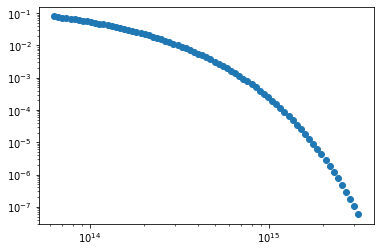

In [16]:
plt.loglog()
plt.scatter(mvec, halo_mass_func[:,0])

In [17]:
# the linear relation lnLbd and lnZeta are logNormal
# the scatter of a logNormal is different from a normal distribution
# see the std from https://en.wikipedia.org/wiki/Log-normal_distribution
def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

In [18]:
# converting std to normal distribution
s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)

# avoid error messages
rho_inv = (1-rho**2)
rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

# defining standirized variables
lbd_std = (lbd - np.exp(ln_lbd_pred))/s_lambda
zeta_std = (zeta - np.exp(ln_zeta_pred))/s_zeta

# lbd_likelihood
lp_lbd  = -rho_inv*lbd_std**2/2 -((lbd-lbd_hat)/lbd_err)**2/2.

# zeta likelihood
lp_zeta = -rho_inv*zeta_std**2/2 -(chisi-np.sqrt(zeta**2+3))**2/2.

# corr likelihod
lp_corr = rho*rho_inv*lbd_std*zeta_std

lp_total_m = lp_lbd+lp_zeta+lp_corr
p_total_m = np.exp(lp_total_m)*halo_mass_func

# integrate over M
p_total = np.trapz(p_total_m, x=mvec/M0, axis=0)

In [19]:
p_total[0]

0.0023325753668892693

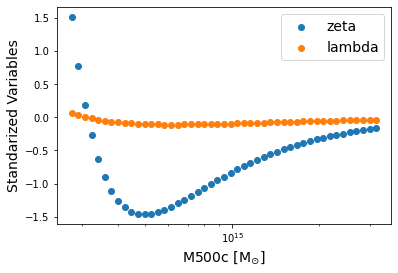

In [20]:
# plt.loglog()
w, = np.where(np.abs(zeta_std[:,0])<2.)
plt.scatter(mvec[w],zeta_std[:,0][w],label='zeta')
plt.scatter(mvec[w],lbd_std[:,0][w],label='lambda')
plt.xscale('log')
plt.xlabel(r'M500c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Standarized Variables',fontsize=14)
plt.legend(fontsize=14)

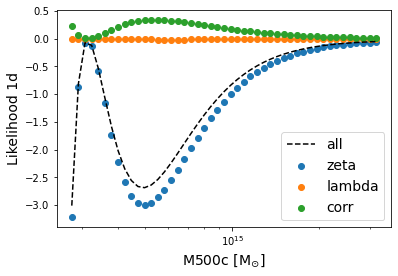

In [21]:
# plt.loglog()
plt.scatter(mvec[w],lp_zeta[:,0][w],label='zeta')
plt.scatter(mvec[w],lp_lbd[:,0][w],label='lambda')
plt.scatter(mvec[w],lp_corr[:,0][w],label='corr')
plt.plot(mvec[w],lp_total_m[:,0][w],label='all',color='k',ls='--')
plt.xscale('log')
plt.xlabel(r'M500c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Likelihood 1d',fontsize=14)
plt.legend(fontsize=14)

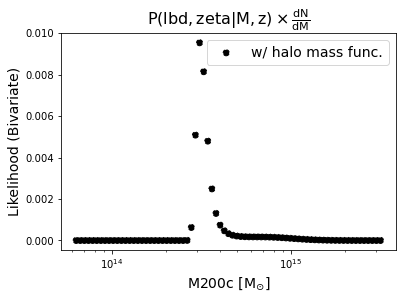

In [22]:
# plt.loglog()
plt.scatter(mvec,p_total_m[:,0],label='w/ halo mass func.',color='k',ls='--')
plt.xscale('log')
plt.xlabel(r'M200c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Likelihood (Bivariate)',fontsize=14)
plt.title(r'$\rm P(lbd, zeta| M, z) \times \frac{dN}{dM}$', fontsize=16)
plt.legend(fontsize=14)

In [23]:
p = compute_dn_dlbd_dzeta(lbd_hat[0], zeta, lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                          scatter_lambda, scatter_sze, rho)
p

array([2.33257537e-03, 9.93903879e-07, 2.12602046e-05, 3.60624282e-05,
       4.13133667e-03, 1.32416313e-04, 3.11747728e-10, 2.56391452e-06,
       1.15355750e-06, 1.24873278e-06])

In [24]:
# res_zeta/1e-12

In [25]:
# integrating over zeta, lambda
nsize = len(lbd_hat)
# integrating over zeta, lambda
res_zeta = np.full((zetavec.size, nsize),np.nan,dtype=float)
res_lbd = np.full((lbdvec.size, nsize),np.nan,dtype=float)

for j,li in enumerate(lbdvec):
    for i,zi in enumerate(zetavec):
        res_zeta[i] = compute_dn_dlbd_dzeta(li, zi, lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                                          scatter_lambda, scatter_sze, rho)
    # integrate over zeta for a given lambda
    res_lbd[j] = np.trapz(res_zeta, axis=0)
# integrate over lambda
prob = np.trapz(res_lbd, x=lbdvec, axis=0)
# normalize over all posibilities
prob = prob/np.sum(prob)
prob

array([0.02991561, 0.07534315, 0.01445104, 0.01690993, 0.34451162,
       0.0110008 , 0.0645981 , 0.04545433, 0.38015729, 0.01765815])

In [26]:
marginalize_over_lbd_zeta(lbd_hat, lbd_err, chisi, ln_lbd_pred, ln_zeta_pred, halo_mass_func,
                              scatter_lambda, scatter_sze, rho)

array([0.02991561, 0.07534315, 0.01445104, 0.01690993, 0.34451162,
       0.0110008 , 0.0645981 , 0.04545433, 0.38015729, 0.01765815])

In [27]:
y = np.vstack([lbd_hat,chisi])
yerr = lbd_err

In [28]:
lnP = log_likelihood(theta, z, y, yerr, eps=1e-9)
lnP

# it takes 2s one evalution on array of 10 clusters

-30.8216808183721

## A meshgrid array of 3D

In [29]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec
mm, zz, ll = np.meshgrid(mvec, zetavec, lbdvec, indexing='ij')
def log_likelihood_vec(theta, z, y, yerr, eps=1e-9):
    # defining variables
    lbd_hat, chisi = y[0], y[1]
    lbd_err = yerr
    probs = []
    for lbd_hat_i, lbd_err_i, chisi_i, z_i in zip(lbd_hat, lbd_err, chisi, z):
        probs.append(_log_likelihood(theta, lbd_hat_i, lbd_err_i, chisi_i, z_i))    
    p = np.array(probs)/np.sum(probs)
    return np.sum(np.log(p))

def _log_likelihood(theta, lbd_hat_i, lbd_err_i, chisi_i, z_i):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, z_i)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, z_i)
    halo_mass_func = halo_mass_function2(z_i)

    hmf = np.tile(halo_mass_func, (len(lbdvec), len(zetavec), 1)).T
    ln_lbd_pred = np.tile(ln_lbd_pred, (len(lbdvec), len(zetavec), 1)).T
    ln_zeta_pred = np.tile(ln_zeta_pred, (len(lbdvec), len(zetavec), 1)).T
    
    # compute dn_dlbd_dzeta_integrand
    p_total_m = compute_dn_dlbd_dzeta_vec(lbd_hat_i, lbd_err_i, chisi_i,
                                          scatter_lambda, scatter_sze, rho,
                                          ln_lbd_pred, ln_zeta_pred, hmf)
    # integrate over M
    p_lbd_zeta = np.trapz(p_total_m, x=mvec, axis=0)

    # integrate over zeta
    p_lbd = np.trapz(p_lbd_zeta, x=zetavec, axis=0)

    # integrate over lambda
    p = np.trapz(p_lbd, x=lbdvec, axis=0)
    return p#np.log(p)

def compute_dn_dlbd_dzeta_vec(lbd_hat_i, lbd_err_i, chisi_i,
                              scatter_lambda, scatter_sze, rho,
                              ln_lbd_pred, ln_zeta_pred, hmf):
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)

    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

    # defining standirized variables
    lbd_std = (ll - np.exp(ln_lbd_pred))/s_lambda
    zeta_std = (zz - np.exp(ln_zeta_pred))/s_zeta

    # lbd_likelihood
    lp_lbd  = -rho_inv*lbd_std**2/2 -((ll-lbd_hat_i)/lbd_err_i)**2/2.

    # zeta likelihood
    lp_zeta = -rho_inv*zeta_std**2/2 -(chisi_i-np.sqrt(zz**2+3))**2/2.

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std

    lp_total_m = lp_lbd+lp_zeta+lp_corr
    p_total_m = np.exp(lp_total_m)*hmf
    return p_total_m

In [46]:
# for a given cluster, i.e. a vector (lbd_hat_i, chisi_i, z_i)

# ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmin(sz_signal[lambda_chisq>0])]
ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmax(lambda_chisq[lambda_chisq>0])]

lbd_hat_i = lambda_chisq[ix]
lbd_err_i = lambda_chisqE[ix]
chisi_i = sz_signal[ix]
z_i = redshift[ix]
print(lbd_hat_i)
print(chisi_i)

203.78017
10.641013


In [47]:
# calling predictions;
ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, z_i)
ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, z_i)
halo_mass_func = halo_mass_function(mvec, z_i)

hmf = np.tile(halo_mass_func, (len(lbdvec), len(zetavec), 1)).T
ln_lbd_pred = np.tile(ln_lbd_pred, (len(lbdvec), len(zetavec), 1)).T
ln_zeta_pred = np.tile(ln_zeta_pred, (len(lbdvec), len(zetavec), 1)).T
print(hmf.shape)

(75, 75, 150)


In [48]:
# converting std to normal distribution
s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)

# avoid error messages
rho_inv = (1-rho**2)
rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

# # defining standirized variables
lbd_std = (ll - np.exp(ln_lbd_pred))/s_lambda
zeta_std = (zz - np.exp(ln_zeta_pred))/s_zeta

# lbd_likelihood
lp_lbd  = -rho_inv*lbd_std**2/2 #-((ll-lbd_hat_i)/lbd_err_i)**2/2.

# zeta likelihood
lp_zeta = -rho_inv*zeta_std**2/2 #-(chisi_i-np.sqrt(zz**2+3))**2/2.

# corr likelihod
lp_corr = rho*rho_inv*lbd_std*zeta_std

lp_total_m = lp_lbd+lp_zeta+lp_corr
p_total_m = np.exp(lp_total_m)*hmf#/M0
#p_total_m = np.where(p_total_m<eps, 0., p_total_m)

# integrate over M
p_lbd_zeta = simps(p_total_m, x=mvec, axis=0)

print(ll.shape)
print(ln_lbd_pred.shape)

(75, 75, 150)
(75, 75, 150)


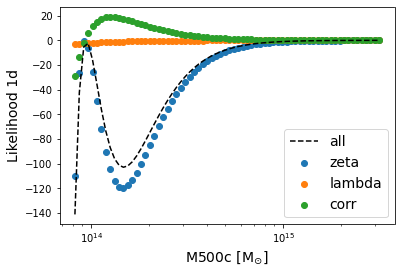

In [49]:
# plt.loglog()
w, = np.where(np.abs(zeta_std[:,0,0])<11.)
plt.scatter(mvec[w],lp_zeta[:,0,0][w],label='zeta')
plt.scatter(mvec[w],lp_lbd[:,0,0][w],label='lambda')
plt.scatter(mvec[w],lp_corr[:,0,0][w],label='corr')
plt.plot(mvec[w],lp_total_m[:,0,0][w],label='all',color='k',ls='--')
plt.xscale('log')
plt.xlabel(r'M500c [M$_{\odot}$]',fontsize=14)
plt.ylabel('Likelihood 1d',fontsize=14)
plt.legend(fontsize=14)

In [50]:
def prob_chisi(zeta, chisi, eps=1e-12):
    res = np.exp(-(chisi-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res#np.where(res<eps,0.,res)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_lbd_hat(lbd, lbd_hat, lbd_error, eps=1e-12):
    res = gaussian(lbd, lbd_hat, lbd_error)
    return res#np.where(res<eps,0.,res)

In [51]:
p_chisi = prob_chisi(zetavec, chisi_i)
p_lbd_hat = prob_lbd_hat(lbdvec, lbd_hat_i, lbd_err_i)

p_chisi = np.tile(p_chisi, (len(lbdvec), 1)).T

# integrate over zeta
p_lbd = simps(p_lbd_zeta*p_chisi, x=zetavec, axis=0)

# integrate over zeta
p = simps(p_lbd*p_lbd_hat, x=lbdvec, axis=0)


In [52]:
doNorm = lambda x: x/np.sum(x)

Text(0.5, 0, 'lambda')

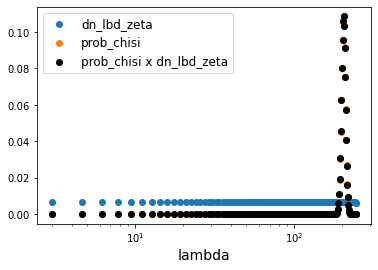

In [53]:
plt.xscale('log')
plt.scatter(lbdvec, doNorm(p_lbd),label='dn_lbd_zeta')
plt.scatter(lbdvec, doNorm(p_lbd_hat),label='prob_chisi')
plt.scatter(lbdvec, doNorm(p_lbd_hat*p_lbd),color='k',label='prob_chisi x dn_lbd_zeta')
plt.legend(fontsize=12)
plt.xlabel('lambda',fontsize=14)

Text(0.5, 0, 'zeta')

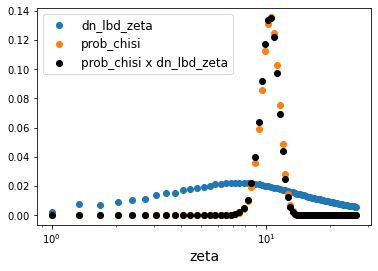

In [54]:
plt.xscale('log')
plt.scatter(zetavec, doNorm(p_lbd_zeta[:,2]),label='dn_lbd_zeta')
plt.scatter(zetavec, doNorm(p_chisi[:,2]),label='prob_chisi')
plt.scatter(zetavec, doNorm(p_lbd_zeta[:,2]*p_chisi[:,2]),color='k',label='prob_chisi x dn_lbd_zeta')
plt.legend(fontsize=12)
plt.xlabel('zeta',fontsize=14)

In [55]:
cpchisi = np.cumsum(p_chisi[:,0]/np.sum(p_chisi[:,0]),axis=0)
cplbdhat= np.cumsum(p_lbd_hat/np.sum(p_lbd_hat),axis=0)

clo,cup = np.interp([0.0001,0.9999],cpchisi,np.arange(len(zetavec))).astype(int)+(0,2)
llo,lup = np.interp([0.0001,0.9999],cplbdhat,np.arange(len(lbdvec))).astype(int)+(0,2)

print(clo,cup)
print(llo,lup)
p_lbd2 = simps(p_lbd_zeta[clo:cup,:]*p_chisi[clo:cup,:], x=zetavec[clo:cup], axis=0)
p2 = simps(p_lbd[llo:lup]*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)

16 40
109 138


In [56]:
precision1 = np.mean(np.abs(1-p_lbd2/p_lbd)*100)
precision2 = np.mean(np.abs(1-p2/p)*100)
print('precision 1: %.2f'%precision1)
print('precision 2: %.2f'%precision2)

precision 1: 0.01
precision 2: 0.02


Text(0.5, 0, 'lambda')

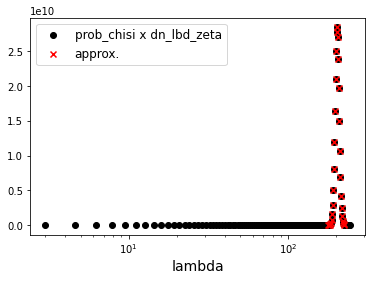

In [57]:
plt.xscale('log')
plt.scatter(lbdvec, p_lbd_hat*p_lbd,color='k',label='prob_chisi x dn_lbd_zeta')
plt.scatter(lbdvec[llo:lup], p_lbd_hat[llo:lup]*p_lbd[llo:lup],color='r',marker='x',label='approx.')
plt.legend(fontsize=12)
plt.xlabel('lambda',fontsize=14)

No handles with labels found to put in legend.


Text(0.5, 0, 'zeta')

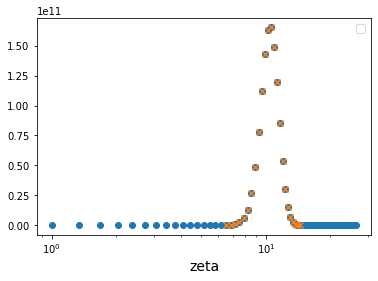

In [58]:
plt.xscale('log')
plt.scatter(zetavec, p_lbd_zeta[:,2]*p_chisi[:,2])
plt.scatter(zetavec[clo:cup], p_lbd_zeta[clo:cup,2]*p_chisi[clo:cup,2], marker='x')
# plt.scatter(zetavec,np.cumsum(p_chisi[:,2]/np.sum(p_chisi[:,2]),axis=0))

plt.legend(fontsize=12)
plt.xlabel('zeta',fontsize=14)


## testing new integration scheme

In [59]:
# taking only points with a significant p_chisi/lbd_hat

def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,2)
    return ilo, iup

In [72]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec
mm, zz, ll = np.meshgrid(mvec, zetavec, lbdvec, indexing='ij')

def log_likelihood_vec2(theta, z, y, yerr, eps=1e-9):
    # defining variables
    lbd_hat, chisi = y[0], y[1]
    lbd_err = yerr
    probs = []
    for lbd_hat_i, lbd_err_i, chisi_i, z_i in zip(lbd_hat, lbd_err, chisi, z):
        probs.append(_log_likelihood2(theta, lbd_hat_i, lbd_err_i, chisi_i, z_i))    
    p = np.array(probs)/np.sum(probs)
    return np.sum(np.log(p))

def _log_likelihood2(theta, lbd_hat_i, lbd_err_i, chisi_i, z_i):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mvec, z_i)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mvec, z_i)
    halo_mass_func = halo_mass_function2(z_i)
    
    # error probabilities
    p_chisi = prob_chisi(zetavec, chisi_i)
    p_lbd_hat = prob_lbd_hat(lbdvec, lbd_hat_i, lbd_err_i)
    
    # take only significant p_lbd_hat values
    llo, lup = slice_array(p_lbd_hat,alpha=1e-4)
    clo, cup = slice_array(p_chisi,alpha=1e-4)
    
    hmf = np.tile(halo_mass_func, (int(lup-llo), int(cup-clo), 1)).T
    ln_lbd_pred = np.tile(ln_lbd_pred, (int(lup-llo), int(cup-clo), 1)).T
    ln_zeta_pred = np.tile(ln_zeta_pred, (int(lup-llo), int(cup-clo), 1)).T
    
    # compute dn_dlbd_dzeta_integrand
    p_total_m = compute_dn_dlbd_dzeta_vec2(lbd_hat_i, lbd_err_i, chisi_i,
                                           scatter_lambda, scatter_sze, rho,
                                           ll[:,clo:cup,llo:lup],zz[:,clo:cup,llo:lup],
                                           ln_lbd_pred, ln_zeta_pred, hmf)
    # integrate over M
    p_lbd_zeta = np.trapz(p_total_m, x=mvec, axis=0)

    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)

    # integrate over lambda
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    return p#np.log(p)

def compute_dn_dlbd_dzeta_vec2(lbd_hat_i, lbd_err_i, chisi_i,
                               scatter_lambda, scatter_sze, rho,
                               lvec, zvec, ln_lbd_pred, ln_zeta_pred, hmf):
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)
    
    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)

    # defining standirized variables
    lbd_std = (lvec - np.exp(ln_lbd_pred))/s_lambda
    zeta_std = (zvec - np.exp(ln_zeta_pred))/s_zeta

    # lbd_likelihood
    lp_lbd  = -rho_inv*lbd_std**2/2

    # zeta likelihood
    lp_zeta = -rho_inv*zeta_std**2/2

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std

    lp_total_m = lp_lbd+lp_zeta+lp_corr
    p_total_m = np.exp(lp_total_m)*hmf
    return p_total_m


In [73]:
log_likelihood_vec2(theta, z, y, yerr, eps=1e-9)

-26.12849964815183

In [74]:
log_likelihood_vec(theta, z, y, yerr, eps=1e-9)

-30.821681497999208

The `log_likelihood_vec2` is much faster, perfoms at 10ms scale while the other are >100ms. Altough the results are a bit different this implementation is more reliable since it follows close Grandis et al. paper's formulas. 